In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import glob
import pathlib
from tensorflow.keras import layers
from tensorflow import keras

# Exploring data sets

In [2]:
import os
for dirpath, dirnames, filenames in os.walk("/kaggle/input/cell-images-for-detecting-malaria/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in '/kaggle/input/cell-images-for-detecting-malaria/'.
There are 3 directories and 0 images in '/kaggle/input/cell-images-for-detecting-malaria/cell_images'.
There are 0 directories and 13780 images in '/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected'.
There are 0 directories and 13780 images in '/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized'.
There are 2 directories and 0 images in '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images'.
There are 0 directories and 13780 images in '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected'.
There are 0 directories and 13780 images in '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized'.


(103, 100, 3)
(190, 145, 3)
(148, 121, 3)
(121, 169, 3)
(145, 106, 3)
(127, 124, 3)
(139, 124, 3)
(133, 115, 3)
(112, 121, 3)
(220, 208, 3)


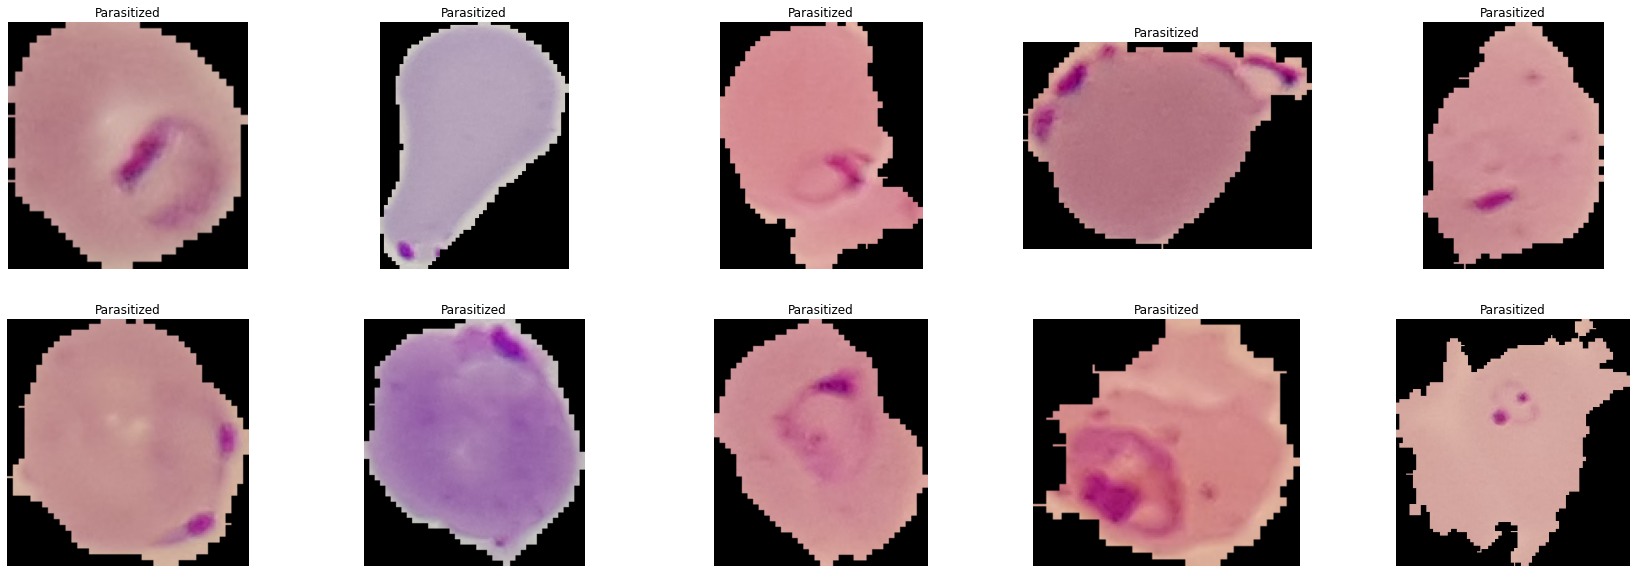

In [3]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  print(img.shape)
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  return img

w = 10
h = 10
fig = plt.figure(figsize=(30, 10))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(view_random_image("/kaggle/input/cell-images-for-detecting-malaria/cell_images/", "Parasitized"))
plt.show()

(139, 136, 3)
(127, 139, 3)
(139, 115, 3)
(112, 130, 3)
(118, 115, 3)
(127, 127, 3)
(130, 121, 3)
(130, 136, 3)
(145, 148, 3)
(148, 136, 3)


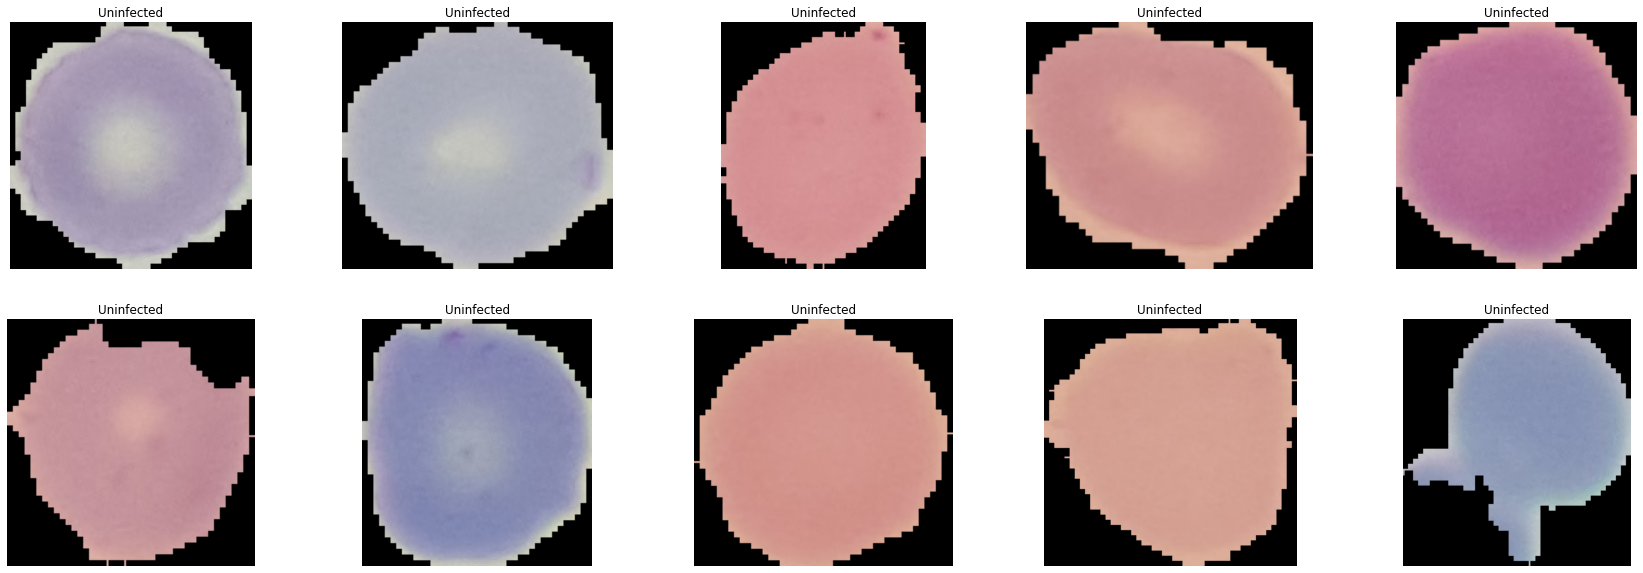

In [4]:
fig = plt.figure(figsize=(30, 10))
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(view_random_image("/kaggle/input/cell-images-for-detecting-malaria/cell_images/", "Uninfected"))
plt.show()

In [5]:
lst = []
dirc_Uninfected = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/"
dirc_Parasitized = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/"
for img in glob.glob(dirc_Uninfected+"*.png"):
    lst.append(mpimg.imread(img).shape)

max(lst), min(lst)

((235, 187, 3), (49, 64, 3))

# Split data to train - valid - test

In [6]:
!ls /kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images

Parasitized  Uninfected


In [7]:
data_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images')

In [8]:
image_count = len(list(data_dir.glob('*/*.png')))
image_count

27558

In [9]:
batch_size = 32
img_height = 64
img_width = 64

train_datagen_augmented = tf.keras.preprocessing.image.ImageDataGenerator(
                                             rescale = 1. / 255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             validation_split=0.2,
                                             horizontal_flip=True) # flip the image on the horizontal axis
train_data = train_datagen_augmented.flow_from_directory(
    data_dir,
    subset = "training",
    seed = 42,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1, rescale = 1./255.)
valid_data = valid_datagen.flow_from_directory(
    data_dir,
    subset = "validation",
    seed = 42,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
)
test_data = valid_datagen.flow_from_directory(
    data_dir,
    subset = "validation",
    seed = 42,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
)

Found 22048 images belonging to 2 classes.
Found 2754 images belonging to 2 classes.
Found 2754 images belonging to 2 classes.


In [41]:
class_names = train_data.class_indices

class_names = list(class_names.keys())
class_names

['Parasitized', 'Uninfected']

In [12]:
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 64, 64, 3)
(32, 2)


# checkpoint - early stop - reduce learning rate

In [13]:
checkpoint_path_v1 = "checkpoint_malaria/checkpoint_v2.h5"

checkpoint_callback_v1 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_v1,
                                                         monitor = "val_loss",
                                                         save_best_only=True,  
                                                         verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2,  patience=10, verbose=1, min_lr=1e-7)


In [15]:
model_1 = keras.models.Sequential([
    keras.layers.Conv2D(16, kernel_size=(3,3), activation="relu", padding="same", input_shape = (64, 64, 3)),
    keras.layers.MaxPool2D(pool_size=(2,2)),
#     keras.layers.BatchNormalization(axis = -1),
#     keras.layers.Dropout(rate=0.2),
    
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPool2D(pool_size=(2,2)),
#     keras.layers.BatchNormalization(axis = -1),
#     keras.layers.Dropout(rate=0.2),
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPool2D(pool_size=(2,2)),

    keras.layers.Conv2D(256, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    
    keras.layers.Dropout(rate=0.2),
    keras.layers.Flatten(),
    
    keras.layers.Dense(300, activation="relu"),
#     keras.layers.BatchNormalization(axis = -1),

#     keras.layers.BatchNormalization(axis = -1),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(2, activation="softmax", name="output_layer")
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#Fit the model
history_v1 = model_1.fit(train_data,
                        epochs=20,
                        validation_data=valid_data,
                        callbacks =  [checkpoint_callback_v1, early_stopping, reduce_lr])

model_1.summary()

Epoch 1/20
689/689 [==============================] - 68s 97ms/step - loss: 0.3118 - accuracy: 0.8545 - val_loss: 0.2001 - val_accuracy: 0.9306

Epoch 00001: val_loss improved from 0.69315 to 0.20005, saving model to checkpoint_malaria/checkpoint_v2.h5
Epoch 2/20
689/689 [==============================] - 67s 97ms/step - loss: 0.1559 - accuracy: 0.9524 - val_loss: 0.2066 - val_accuracy: 0.9375

Epoch 00002: val_loss did not improve from 0.20005
Epoch 3/20
689/689 [==============================] - 67s 97ms/step - loss: 0.1380 - accuracy: 0.9566 - val_loss: 0.1758 - val_accuracy: 0.9346

Epoch 00003: val_loss improved from 0.20005 to 0.17583, saving model to checkpoint_malaria/checkpoint_v2.h5
Epoch 4/20
689/689 [==============================] - 67s 98ms/step - loss: 0.1320 - accuracy: 0.9574 - val_loss: 0.1960 - val_accuracy: 0.9317

Epoch 00004: val_loss did not improve from 0.17583
Epoch 5/20
689/689 [==============================] - 70s 101ms/step - loss: 0.1266 - accuracy: 0.9605

In [17]:
model_1.evaluate(test_data)

87/87 [==============================] - 4s 49ms/step - loss: 0.2858 - accuracy: 0.9306


[0.2858301103115082, 0.9306463599205017]

In [18]:
model_1.save("cnn_malaria_classification.h5")

In [19]:
load = keras.models.load_model("/kaggle/working/cnn_malaria_classification.h5")
load.evaluate(test_data)

87/87 [==============================] - 5s 50ms/step - loss: 0.2858 - accuracy: 0.9306


[0.2858301103115082, 0.9306463599205017]

In [42]:
def load_and_prep_image(filename, img_shape=64, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

path_image = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144348_cell_144.png"
# Load the image and make predictions
img = load_and_prep_image(path_image, scale=True) # don't scale images for EfficientNet predictions
pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]

pred_class = class_names[pred_prob.argmax()] # find the predicted class 
pred_class

Cleanup called...


'Parasitized'

In [48]:
len(pred_prob)

1

In [57]:
for layer in model_1.layers[:10]:
    print(layer.name)

conv2d_5
max_pooling2d_5
conv2d_6
max_pooling2d_6
conv2d_7
max_pooling2d_7
conv2d_8
max_pooling2d_8
conv2d_9
max_pooling2d_9
dropout_3
